# Normalization vs Standardization (with simple visuals)

This notebook is a **gentle introduction** to feature scaling for brand‑new learners. We cover only two tools:

- **Normalization (Min–Max):** squeezes values into a fixed range, usually [0, 1].
- **Standardization (Z-score):** shifts the average to 0 and scales spread to 1.

You’ll see **what they do**, **why they’re needed**, and **when to use or skip them**, with **simple plots** and **plain explanations** right after each figure.

**Quick intuition:** Different features can live on very different numeric scales (e.g., *glucose* ≈ 100 vs *gene score* ≈ 0.01). Many models that rely on **distance** or **gradient steps** get confused by this mismatch. Scaling makes comparisons fair.


### Imports

In [7]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.datasets import make_classification, load_breast_cancer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

np.random.seed(7)


### A tiny dataset with mismatched scales
We’ll make two features:
- **feature_big**: values around thousands (pretend this is something like *hospital charges*),
- **feature_small**: values around 0.01 (pretend this is a normalized *gene score*).

Then we’ll peek at a scatter plot **before** any scaling.

In [8]:

# Create toy data
n = 40
feature_big = np.random.normal(loc=3000, scale=400, size=n)  # big numbers
feature_small = np.random.normal(loc=0.01, scale=0.005, size=n)  # tiny numbers

X = np.column_stack([feature_big, feature_small])
df = pd.DataFrame(X, columns=["feature_big", "feature_small"])


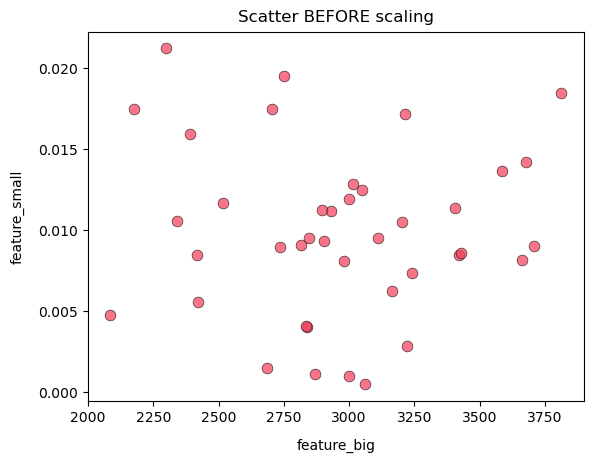

In [14]:
# Simple scatter BEFORE scaling
plt.figure()
plt.scatter(df["feature_big"], df["feature_small"], s=60, 
            linewidths=0.5,
            edgecolor='black',
            alpha=0.7,
            color='#f53b57')
plt.title("Scatter BEFORE scaling", pad=7)
plt.xlabel("feature_big",labelpad=10)
plt.ylabel("feature_small",labelpad=10)
# plt.style.use('seaborn-v0_8-ticks')
plt.style.use('seaborn-v0_8-pastel')
plt.show()

**What you’re seeing:** The x‑axis spans **thousands**, while the y‑axis hugs **near zero**. To a distance‑based model (like k‑Nearest Neighbors), almost all variation along the y‑axis is negligible compared to the x‑axis. The model would mostly pay attention to `feature_big` and almost ignore `feature_small`. That’s the core reason **scaling helps** — it makes features comparable.


## 2) Normalization (Min–Max)
**What it does:** Moves each feature into a **fixed range**, usually [0, 1].

**Why it helps:** Puts everything on the same **min-to-max** scale, which is handy for methods that compare distances.

**Formula:**
$$x_{\text{norm}} = \frac{x - x_{\min}}{x_{\max} - x_{\min}}$$

In [29]:
mm = MinMaxScaler()
X_mm = mm.fit_transform(df[["feature_big", "feature_small"]])

df_mm = pd.DataFrame(X_mm, columns=["feature_big_mm", "feature_small_mm"])


Text(0, 0.5, 'feature_small')

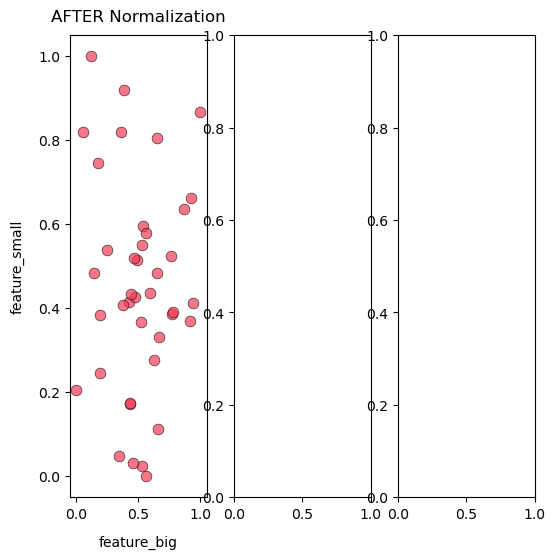

In [31]:
fig , ax = plt.subplots(1,3,figsize=(6,6))
ax= ax.flatten()
# Scatter AFTER Min–Max
ax[0].scatter(df_mm["feature_big_mm"], df_mm["feature_small_mm"], 
            s=60,
            edgecolors='black',
            linewidths=0.5,
            color='#f53b57',
            alpha=0.7)
ax[0].set_title("AFTER Normalization",pad=10)
ax[0].set_xlabel("feature_big",labelpad=10)
ax[0].set_ylabel("feature_small",labelpad=10)

# Show individual histograms AFTER Min–Max
ax[1].hist(df_mm["feature_big_mm"], bins=10, 
         edgecolor='black',
         color='#0be881',
         alpha=0.7
)
ax[1].title("Histogram AFTER Min–Max: feature_big → [0,1]",pad=10)
ax[1].xlabel("feature_big_mm",labelpad=10)
ax[1].ylabel("Count",labelpad=10)

ax[1].figure()
ax[1].hist(df_mm["feature_small_mm"], bins=10,
         color='#00d8d6',
         edgecolor='black',
         alpha=0.7
         )
plt.title("Histogram AFTER Min–Max: feature_small → [0,1]",pad=10)
plt.xlabel("feature_small_mm",labelpad=10)
plt.ylabel("Count",labelpad=10)
fig.show()


**How to read these plots:** After Min–Max, **both features live between 0 and 1**. Distances are now **comparable**: a move of 0.1 along the x‑axis means the same normalized change as 0.1 along the y‑axis. The **shape** of each distribution is preserved — we only **rescaled** the numbers into a common range.


## 3) Standardization (Z‑score)
**What it does:** Centers each feature at **0** and scales its spread (standard deviation) to **1**.

**Why it helps:** Many linear/gradient‑based models behave better when features have **similar spread** around 0.

**Formula:**
$$x_{\text{std}} = \frac{x - \mu}{\sigma}$$

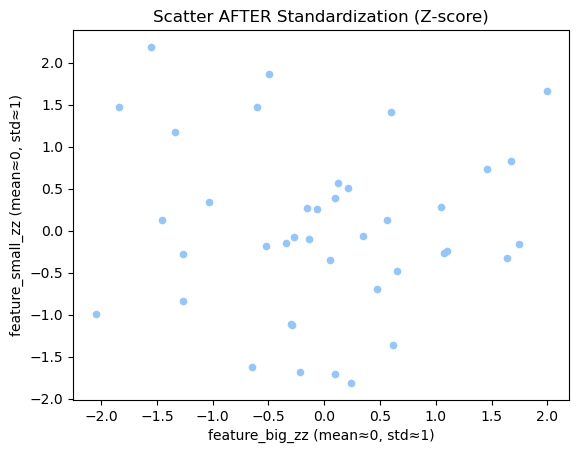

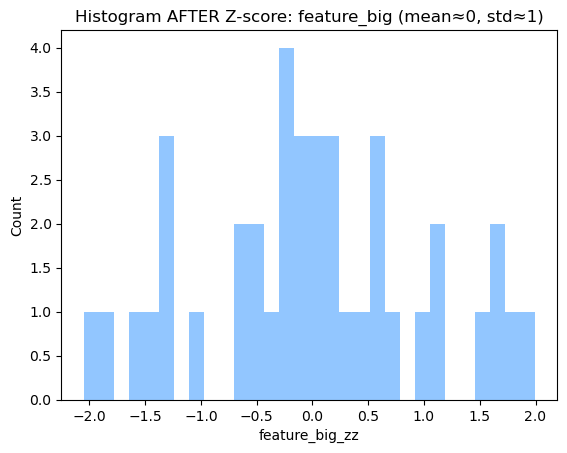

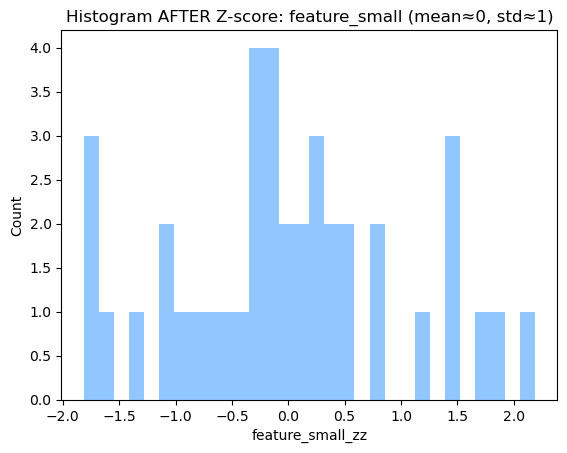

In [11]:

zz = StandardScaler()
X_zz = zz.fit_transform(df[["feature_big", "feature_small"]])
df_zz = pd.DataFrame(X_zz, columns=["feature_big_zz", "feature_small_zz"])

# Scatter AFTER Z-score
plt.figure()
plt.scatter(df_zz["feature_big_zz"], df_zz["feature_small_zz"], s=40)
plt.title("Scatter AFTER Standardization (Z-score)")
plt.xlabel("feature_big_zz (mean≈0, std≈1)")
plt.ylabel("feature_small_zz (mean≈0, std≈1)")
plt.show()

# Histograms AFTER Z-score
plt.figure()
plt.hist(df_zz["feature_big_zz"], bins=30)
plt.title("Histogram AFTER Z-score: feature_big (mean≈0, std≈1)")
plt.xlabel("feature_big_zz")
plt.ylabel("Count")
plt.show()

plt.figure()
plt.hist(df_zz["feature_small_zz"], bins=30)
plt.title("Histogram AFTER Z-score: feature_small (mean≈0, std≈1)")
plt.xlabel("feature_small_zz")
plt.ylabel("Count")
plt.show()


**How to read these plots:** After Z‑score scaling, both features are **centered around 0** and have **similar spread** (≈1). Models like **Logistic Regression, SVM, and many Neural Nets** often train more **stably** and **fairly** compare features in this space.


## 4) A tiny demo: kNN feels the difference
We’ll run a simple **k‑Nearest Neighbors** classifier three ways on the breast cancer dataset:
1) **No scaling**
2) **Min–Max**
3) **Z‑score**

This isn’t about chasing the best score — it’s just to **show sensitivity to scaling**.

In [12]:

data = load_breast_cancer()
X = data.data
y = data.target

def cv_acc(pipe):
    return cross_val_score(pipe, X, y, cv=5, scoring="accuracy").mean()

# No scaling
pipe_raw = Pipeline([("impute", SimpleImputer(strategy="median")),
                     ("clf", KNeighborsClassifier(n_neighbors=5))])

# Min–Max
pipe_mm = Pipeline([("impute", SimpleImputer(strategy="median")),
                    ("scale", MinMaxScaler()),
                    ("clf", KNeighborsClassifier(n_neighbors=5))])

# Z‑score
pipe_zz = Pipeline([("impute", SimpleImputer(strategy="median")),
                    ("scale", StandardScaler()),
                    ("clf", KNeighborsClassifier(n_neighbors=5))])

scores = {
    "kNN (no scaling)": round(cv_acc(pipe_raw), 4),
    "kNN + Min–Max": round(cv_acc(pipe_mm), 4),
    "kNN + Z‑score": round(cv_acc(pipe_zz), 4)
}

scores


{'kNN (no scaling)': 0.9279, 'kNN + Min–Max': 0.9719, 'kNN + Z‑score': 0.9649}

**Takeaway:** kNN uses **distances**, so putting features on a fair scale usually **helps**. Which scaler wins can vary a bit by dataset, but the main point is: **scaling matters** for distance‑based models.


###  When to use each (and when not to)
**Use scaling (Normalization or Standardization) when…**
- Your model is **distance‑based** or **gradient‑based** (kNN, SVM, Logistic/Linear Regression, Neural Nets, PCA, k‑Means, etc.).
- Different features have **very different units/ranges** (e.g., age vs counts vs lab values).

**Prefer Normalization (Min–Max) when…**
- You want features strictly in a **bounded range** (e.g., [0, 1]).
- A downstream step expects **inputs between 0 and 1** (some neural network setups).

**Prefer Standardization (Z‑score) when…**
- You’re using methods that assume **zero mean** and **unit variance** behavior for stability.
- You want to keep the notion of **how many standard deviations** a value is from average.

**Usually skip scaling when…**
- You’re using **tree‑based models** (Decision Trees, Random Forests, Gradient Boosted Trees). They split on thresholds and typically **don’t need** feature scaling.


###  Common beginner pitfalls
1) **Data leakage:** Fit your scaler **only on training data**. Use a **Pipeline** so cross‑validation stays clean.
2) **Scaling categorical codes:** Don’t scale integer codes that actually represent categories.
3) **Outliers (FYI):** We didn’t cover them here, but large outliers can distort Min–Max/Z‑score. When outliers are severe, consider other strategies (e.g., outlier‑robust scaling) — but that’s for later.


###  Quick practice ideas
- Replace k=5 with k=3 and k=15 in kNN — how do the scores change with/without scaling?
- Try the scatter and histograms on your **own dataset** and see how the shapes change.
- Re‑run the toy demo with **only one feature** wildly scaled — watch how much that single feature dominates without scaling.
